In [1]:
#importing required libraries
import re

from nltk.corpus import twitter_samples
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

import matplotlib.pyplot as plt 

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim_models
import pprint

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))

In [3]:
#pre-processing text
def get_tokens(text):
    cleaned_tokens = []
    
    #converting string to lower case
    text = text.lower()
    
    #removing hyperlinkss
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*(),]|'
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    
    #removing tags starting with @
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    
    #removing next line characters
    text = re.sub("\n"," ", text)
    
    #removing punctuations
    text = re.sub('[:)({},;?<>!*&]', '', text)
    
    #removing numeric characters
    text = re.sub(r'[0-9]', '', text)
    
    #removing additional white space
    text = re.sub(' +', ' ', text)
    
    for token in text.split():
        if token not in stop and len(token)>1:
            cleaned_tokens.append(lemmatizer.lemmatize(token))
    return cleaned_tokens

#### Data

Here, I am using NLTK's tweets for data. I will be focussing only on positive tweets from dataset for topic modelling.

In [4]:
positive_tweets = twitter_samples.strings('positive_tweets.json')

#Total number of tweets
len(positive_tweets)

5000

In [5]:
#sample data
positive_tweets[:6]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM']

##### As we can see above, tweets have people and other pages tagged, hyperlinks included, punctuations and numbers (including contacts) included. We would be cleaning those as part of pre-processing using the function defined above and then creating a list of clean tokens from these tweets.

In [6]:
clean_tokens_list = []
for i in range(len(positive_tweets)):
    clean_tokens_list.append(get_tokens(positive_tweets[i]))
    
#sample of clean token list    
clean_tokens_list[:4]

[['#followfriday', 'top', 'engaged', 'member', 'community', 'week'],
 ['hey',
  'james',
  'odd',
  'please',
  'call',
  'contact',
  'centre',
  'able',
  'assist',
  'many',
  'thanks'],
 ['listen', 'last', 'night', 'bleed', 'amazing', 'track.', 'scotland'],
 ['congrats']]

In [7]:
# Using dictionary to get unique words from our corpus
dict_ = corpora.Dictionary(clean_tokens_list)

print(dict_)

Dictionary(8257 unique tokens: ['#followfriday', 'community', 'engaged', 'member', 'top']...)


In [8]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary 
doc_term_matrix = [dict_.doc2bow(i) for i in clean_tokens_list]
doc_term_matrix[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

### Using Gensim's LDA model for topic modelling

In [9]:
# Initiating an object for the LDA model
Lda = gensim.models.ldamodel.LdaModel

In [10]:
# Passing parameters to the model.
# Let's start with 5 topics.

ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dict_, passes=8, random_state=4, eval_every=None)

In [11]:
# Prints the topics with the importance values
ldamodel.print_topics()

[(0,
  '0.028*"love" + 0.028*"thanks" + 0.021*"day" + 0.015*"great" + 0.015*"lt" + 0.014*"new" + 0.014*"hi" + 0.014*"like" + 0.010*"follow" + 0.010*"via"'),
 (1,
  '0.012*"friday" + 0.010*"nice" + 0.009*"welcome" + 0.009*"yes" + 0.009*"happy" + 0.009*"friend" + 0.008*"one" + 0.008*"make" + 0.008*"i\'m" + 0.008*"well"'),
 (2,
  '0.024*"follow" + 0.015*"back" + 0.011*"amp" + 0.011*"like" + 0.007*"think" + 0.007*"thank" + 0.007*"know" + 0.006*"lol" + 0.005*"go" + 0.005*"everyone"'),
 (3,
  '0.021*"thank" + 0.019*"happy" + 0.011*"birthday" + 0.008*"done" + 0.007*"much" + 0.007*"i\'m" + 0.007*"get" + 0.006*"day" + 0.006*"go" + 0.004*"thanks"'),
 (4,
  '0.022*"good" + 0.010*"morning" + 0.009*"want" + 0.007*"thanks" + 0.007*"really" + 0.007*"time" + 0.007*"please" + 0.006*"u" + 0.005*"yeah" + 0.005*"that\'s"')]

In [12]:
# Printing top 5 keywords in a topic in a different format
pprint.pprint(ldamodel.top_topics(doc_term_matrix,topn=5))

[([(0.023591205, 'follow'),
   (0.014724118, 'back'),
   (0.011341561, 'amp'),
   (0.011161325, 'like'),
   (0.0070946435, 'think')],
  -3.1374068446786536),
 ([(0.021612646, 'good'),
   (0.009675684, 'morning'),
   (0.008525388, 'want'),
   (0.0071186395, 'thanks'),
   (0.007087154, 'really')],
  -5.507400335664729),
 ([(0.02806476, 'love'),
   (0.027616661, 'thanks'),
   (0.020616857, 'day'),
   (0.015356291, 'great'),
   (0.014820266, 'lt')],
  -7.370038323854703),
 ([(0.020910114, 'thank'),
   (0.018588291, 'happy'),
   (0.011114026, 'birthday'),
   (0.007822032, 'done'),
   (0.0071327616, 'much')],
  -9.50261152483046),
 ([(0.012380505, 'friday'),
   (0.010103472, 'nice'),
   (0.009403816, 'welcome'),
   (0.009323046, 'yes'),
   (0.008897418, 'happy')],
  -9.711037259991462)]


In [13]:
# displaying topics in interactive format

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dict_)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.185981  0.070444       1        1  23.443275
3     -0.136315  0.077443       2        1  19.956837
1     -0.048549  0.107504       3        1  19.619812
4     -0.047883 -0.154449       4        1  18.970856
2      0.046766 -0.100942       5        1  18.009220, topic_info=        Term        Freq       Total Category  logprob  loglift
87    follow  185.000000  185.000000  Default  30.0000  30.0000
84      love  237.000000  237.000000  Default  29.0000  29.0000
44     happy  152.000000  152.000000  Default  28.0000  28.0000
200       lt   97.000000   97.000000  Default  27.0000  27.0000
226     good  175.000000  175.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
107    today   19.460526   70.502104   Topic5  -5.5554   0.4270
342      let   17.338718   60.943611   Topic5  -5.6709   0.4573
95       get   18.643922  135.344217   Topic5  -5.5983  -0.2680
418  morning   17.229418   88.636526   Topic5  -5.6772   0.0764
173        u   14.845254   78.565513   Topic5  -5.8261   0.0480

[329 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
2747      1  0.980358  #bajrangibhaijaanhighestweek
941       3  0.898745                    #braindots
1032      5  0.965357    #choiceinternationalartist
985       1  0.234092                           #ff
985       2  0.058523                           #ff
...     ...       ...                           ...
275       3  0.937873                           yes
552       5  0.939184                     yesterday
148       1  0.961391                         youth
206       2  0.970086                       youtube
1610      5  0.977289                            ❤️

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

- It's good to have non-overlapping circles in above display to distinguish between topics. 
- Clicking on any cicrle would show the estimated term frequency of that word in that topic.

### Coherence Topics

- Coherence checks the similarity of words in a given topic.
- Higher the coherence score, better the topic modelling.
- We can check the coherence score for our current model with the code below and later try to plot a graph of coherence scores for different number of topics.

In [14]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_tokens_list, dictionary=dict_, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3442211789673804


In [15]:
# defining function to computer coherence values for different number of topics
def get_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(doc_term_matrix, num_topics=num_topics, id2word = dict_, passes=8, random_state=4, eval_every=None)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
model_list, coherence_values = get_coherence_values(dictionary=dict_, corpus=doc_term_matrix, texts=clean_tokens_list, start=2, limit=11, step=2)

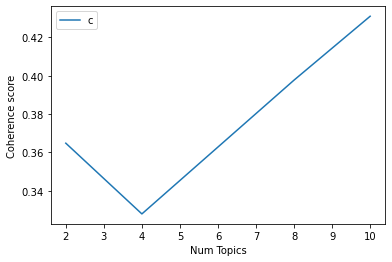

In [17]:
#display coherence values based on above computation
limit=11; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- In the above plot, we can see the coherence scores for different number of topics.
- We now choose the number of topics based on highest value of coherence scores.

In [18]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]

In [19]:
print("Highest Coherence Value: {} \nNumber of Topics: {}".format(round(coherence_values[best_result_index],2), (best_result_index+1)*2))

Highest Coherence Value: 0.43 
Number of Topics: 10


In [20]:
# displaying topics and its keywords based on the optimal model as per coherence scores.
pprint.pprint(optimal_model.top_topics(doc_term_matrix,topn=10))

[([(0.06417122, 'love'),
   (0.052672602, 'thank'),
   (0.029837495, 'lt'),
   (0.028743383, 'happy'),
   (0.02565253, 'see'),
   (0.019274238, 'hi'),
   (0.018021453, 'birthday'),
   (0.017198997, 'lot'),
   (0.012083909, 'much'),
   (0.010127305, 'follow')],
  -4.720479112476311),
 ([(0.022236634, 'friday'),
   (0.018440336, 'nice'),
   (0.017400216, 'morning'),
   (0.016329633, 'happy'),
   (0.015412847, 'welcome'),
   (0.0136224395, 'make'),
   (0.011886338, 'hope'),
   (0.010982357, 'lovely'),
   (0.010834674, 'day'),
   (0.010075626, 'thanks')],
  -4.993534428396525),
 ([(0.02065375, 'know'),
   (0.020307757, 'get'),
   (0.016048405, 'u'),
   (0.015111372, 'please'),
   (0.0145722525, 'think'),
   (0.009416905, 'cool'),
   (0.008965552, 'like'),
   (0.008137338, 'want'),
   (0.0078100744, 'today'),
   (0.0075087594, 'hey')],
  -5.5770384891057185),
 ([(0.041224327, 'thanks'),
   (0.028441932, 'day'),
   (0.023388147, 'new'),
   (0.016456157, 'great'),
   (0.0164338, 'via'),
   (0

In [21]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dict_)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.176774 -0.050279       1        1  13.466782
1     -0.015247  0.219098       2        1  11.829606
9     -0.128659 -0.038635       3        1  11.498604
5     -0.080085 -0.062632       4        1  10.374751
8      0.088514  0.041712       5        1  10.062646
3     -0.012376 -0.024520       6        1   9.418421
2      0.066407 -0.147582       7        1   9.296932
4     -0.010969  0.124901       8        1   9.270017
7      0.147107 -0.031271       9        1   8.199464
6      0.122083 -0.030791      10        1   6.582777, topic_info=         Term        Freq       Total Category  logprob  loglift
84       love  238.000000  238.000000  Default  30.0000  30.0000
152     thank  203.000000  203.000000  Default  29.0000  29.0000
87     follow  190.000000  190.000000  Default  28.0000  28.0000
226      good  178.000000  178.000000  Default  27.0000  27.0000
200        lt   96.000000   96.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
24   congrats    8.434155   18.589680  Topic10  -5.3851   1.9304
426       try    7.845515   26.131564  Topic10  -5.4574   1.5175
600       guy    8.517630   47.677842  Topic10  -5.3752   0.9984
21      night    8.144410   48.229995  Topic10  -5.4201   0.9421
146      yeah    7.024512   45.193056  Topic10  -5.5680   0.8592

[566 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
2747      1  0.919732  #bajrangibhaijaanhighestweek
941       9  0.978110                    #braindots
1787      7  0.908593                     #ceomonth
1032      5  0.947792    #choiceinternationalartist
985       2  0.273304                           #ff
...     ...       ...                           ...
1019      6  0.691748                          you.
148       1  0.945047                         youth
206       8  0.931874                       youtube
2408      8  0.914375                           yup
1610      6  0.975670                            ❤️

[956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 10, 6, 9, 4, 3, 5, 8, 7])

- From the above we can deduce that optimal model based on coherence score has 10 topics.
- Though each topic might not have a dominant keyword describing it, we can see some differences within topics.
- For example, topic 2 seems to be about greetings and wishes while topic 5 is more about positive sentiments like fun, love and smile.

### Sklearn implementation with TF-IDF

In [22]:
# import libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

In [23]:
vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)

In [24]:
arr = vectorizer.fit_transform(clean_tokens_list)
arr

<5000x8257 sparse matrix of type '<class 'numpy.float64'>'
	with 27322 stored elements in Compressed Sparse Row format>

In [25]:
vocab = vectorizer.get_feature_names()
vocab

['""',
 '"a',
 '"acid',
 '"anghel"',
 '"annual".',
 '"apple',
 '"asshole"',
 '"becoming',
 '"bests"',
 '"birmingham',
 '"building',
 '"but',
 '"calm',
 '"cause',
 '"central"',
 '"chinas',
 '"currys".',
 '"d',
 '"damn',
 '"dark"',
 '"day',
 '"deaf',
 '"do',
 '"fleekile',
 '"gleam',
 '"good',
 '"gt',
 '"hey',
 '"hulk"',
 '"i',
 '"i\'ll',
 '"jalulu"',
 '"jojo"',
 '"keep',
 '"kuffar"',
 '"labs"',
 '"laser-like"',
 '"let',
 '"look...',
 '"national',
 '"ngga',
 '"not',
 '"nth"',
 '"oh',
 '"ok',
 '"omg',
 '"our"',
 '"outboarding"',
 '"outside"',
 '"p"',
 '"ps',
 '"rally"',
 '"rod',
 '"see',
 '"she\'s',
 '"snark',
 '"swiftmas"',
 '"thank',
 '"thanks',
 '"that\'s',
 '"the',
 '"this',
 '"tipping',
 '"today',
 '"up',
 '"w"',
 '"we"',
 '"welcome',
 '"who\'s',
 '"whomosexual"',
 '"why',
 '"wtf',
 '"x"',
 '"yeah',
 '"you',
 '"z',
 '##bbmme',
 '##segalakatakata',
 '#actuallythough',
 '#addme',
 '#addmeonbbm',
 '#addmeonsnapchat',
 '#agnezmo',
 '#airforce',
 '#airport',
 '#akshaymostlovedsuperstarever

In [26]:
display(len(vocab))

8257

In [31]:
lda_model = LatentDirichletAllocation(n_components = 10, max_iter = 8, random_state = 2)

X_topics = lda_model.fit_transform(arr)

topic_words = lda_model.components_

In [32]:
#  Define the number of Words that we want to print in every topic : n_top_words
n_top_words = 6

for i, topic_dist in enumerate(topic_words):
    
    sorted_topic_dist = np.argsort(topic_dist)
    
    topic_words = np.array(vocab)[sorted_topic_dist]
    
    topic_words = topic_words[:-n_top_words:-1]
    print ("Topic", str(i+1), topic_words)

Topic 1 ['wait' "can't" '#ff' 'thankyou' 'look']
Topic 2 ['via' 'follower' 'new' 'unfollowers' 'arrived.']
Topic 3 ['follow' 'back' 'amp' 'fback' 'friday']
Topic 4 ['welcome' 'birthday' 'done' 'happy' 'night']
Topic 5 ['love' 'lt' 'hi' 'see' 'bestfriend']
Topic 6 ['thanks' 'know' 'enjoy' 'friend' 'let']
Topic 7 ['okay' 'haha' 'week' 'top' 'community']
Topic 8 ['yes' 'like' 'thank' 'followed' 'glad']
Topic 9 ['thank' 'nice' 'much' 'one' 'following']
Topic 10 ['goodnight' "i'm" 'hey' 'go' 'pic']


### References:

https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
    
https://www.kaggle.com/code/canggih/topic-modeling/notebook
    
https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
